# Interpreting the I3D Model with Feature Visualizations and Saliency Maps
One of the main criticisms of deep learning models is that they act as “black boxes” that provide no feedback about the actual features being learned. From a research perspective, this limits intuition and understanding of the effectiveness of deep models. From an engineering perspective, engineers may risk deploying models that perform well in a controlled training environment, but are actually fragile in the real world.  

In recent years, there has been many techniques developed to provide some interpretability of the parameters and performance of deep models. One popular technique is feature visualization by optimization. As Prof. Listgarten mentioned in lecture, feature visualization by optimization actually went viral in mainstream media back in 2015 under the name of “Google Deep Dream.” In short, feature visualization allows us to generate images by performing gradient ascent on an input image toward a target class (we formalize the optimization problem in a later section). These visualizations will then allow engineers/researchers to investigate whether the model has actually learned reasonable features of an object class. Below is a famous example of this technique in action from Google’s Research Blog (the same examples Prof. Listgarten showed in lecture).

<img src="./files/images/deepdream_example1.png">
<figcaption><center>image from https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html</center></figcaption>

We can see that the the model has captured the “essence” of these classes pretty effectively. However, when they visualized “dumbbells” they got something unexpected: 

<img src="./files/images/deepdream_example2.png">
<figcaption><center>image from https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html</center></figcaption>

Observing the visualizations, we see that the model has learned that dumbbells seem to always be accompanied by a person holding/lifting them rather than just the dumbbell itself. This reveals that the model was likely only trained on dumbbells being lifted rather than dumbbells alone. This example demonstrates how one can use visualizations to catch faulty models. 

Another commonly used technique is creating saliency maps. These maps provide a visualization of the “impact” of each individual pixel on the final classification score. With this technique, engineers/researchers can provide insight on specific parts of an input that resulted in the classification. 

<img src="./files/images/saliency_example1.png">
<figcaption><center>image from https://arxiv.org/pdf/1312.6034v2.pdf</center></figcaption>


In the image above, the brightness of the pixel is proportional to “impact”. We see that pixels with water are actually important when classifying a “sailboat.” While this could be desired behavior (boats are typically in water), it could also suggest that the model is weak at classifying boats that are out of the water. For any service that utilizes machine learning, the capability to explain why a model made a particular decision on a particular input is vital. Later on we will elaborate on the details on of how these maps are generated.

**The goal of our project is to explore how these techniques generalize to video data**. While all of these techniques have been thoroughly explored and developed with static image data, to our knowledge there are no published examples of these techniques performed on video data. Video data presents a set of new challenges that we attempt to overcome in this project. How will the large input size of videos affect computational complexity? How can we enforce continuity between frames when we visualize videos? **Since the results are subjective and qualitative in nature, our project will be a more “tutorial-like” walkthrough of the different regularization techniques we implemented and the corresponding results** (as opposed to a typical paper with results and accuracies). We document each technique we used and provide sample GIFS on the outcome. In addition, we will provide commentary on how our results may suggest bugs/success with the model.


# Class Visualization
Starting with a random noise gif and performing gradient ascent toward a target action class, one can generate an a gif that the network will recognize as the target class. However, naively attempting this will result in adversarial images (https://blog.openai.com/adversarial-example-research/). One must employ several regaulization techniques to generate images that resemble the desired class. 

We formalize the problem in a similiar fashion as [3]. Without loss of generailty, let us consider only the RBG input. The optical flow formalization only differs from RGB in dimensions. Let $x \in R^{NxHxWxC}$ be a RGB video where $N$ is the number of frames, $H$ and $W$ are the height and width respectively, and $C$ is the number of the color channels. For the i3d model, $H=W=224$, $C=3$, and $N=25$. The number of frames can be arbitrarily long or short for visualization, but we chose 25 as that is the frame input length at test time for the i3d model. A large $N$ can result in high computation costs, while a small $N$ results in visualizations that are limited in expressing motion. 

Now, let $y$ be the target class. Let $s_y(x)$ be the logits (scores before the final softmax layer) that the i3d model assigns to the image $x$ for class $y$. Our goal we can now frame our objective as the folowing optimization problem:

$$
x^* = \arg\max_x s_y(x) - R_\theta(x)
$$

where $R_\theta$ is a paramterized regularization function that regularizes images both explicitly and implicitly. Since the regularizer function can be very complex (as described later) and no closed-form solution exists, we resort to solving this optimization problem with gradient ascent. We compute gradients of $s_y(x)$ with respect to the generated video $x$. 

Our primary explicit regualization is L2 regularization of the form 

$$
R_\theta(x) = \lambda \|x\|_2^2
$$ 

and our primary implicit regularization (as implemented in [3]) is performed by periodically blurring the generated image with a gaussian filter. These two intial regularizing operations were good enough to create baseline results, but additional operations are also used and listed below:
1. Jitter - randomly jitter pixels around between iterations
2. Scale - scale the video and then crop after $\theta$ iterations
3. Time blur - gaussian blur across frames
4. Clipping - clip pixels that fall out of a certain range

More info about class visualization is summarized very well here: https://distill.pub/2017/feature-visualization/

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [1]:
"""
Some setup. 
Installations are the same for the i3d model, which can be found here: https://github.com/deepmind/kinetics-i3d
Make sure i3d.py is in the same directory as this notebook.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio

# simply selects which gpu to use
# these lines may very depending on hardware
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import scipy.ndimage as nd

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14594186299499423937
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7919681536
locality {
  bus_id: 1
}
incarnation: 930609617733691846
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [2]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

In [3]:
"""
Run sample (playing cricket) prediction with joint model
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468643

Top classes and probabilities
1.0 41.81368 playing cricket
1.497162e-09 21.493984 hurling (sport)
3.843087e-10 20.134104 catching or throwing baseball
1.549236e-10 19.22559 catching or throwing softball
1.1360122e-10 18.915352 hitting baseball
8.801088e-11 18.660118 playing tennis
2.441542e-11 17.377872 playing kickball
1.153184e-11 16.62777 playing squash or racquetball
6.131901e-12 15.996161 shooting goal (soccer)
4.3917357e-12 15.662382 hammer throw
2.213431e-12 14.977201 golf putting
1.6307096e-12 14.671672 throwing discus
1.54561

In [4]:
"""
Define some helper functions
"""
from scipy.ndimage.filters import gaussian_filter1d

# blurs image
def blur_image(X, sigma=1):
    # start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    # print("Blur time", time.time()-start)
    return X

# transforms flow input into a form that can be visualize
def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)

# saves final video/frames and saves a .gif file
def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

# returns a decreasing sigma value for gaussian blurring
def calc_sigma(curr, total, sigma):
    if curr > .75*total:
        return sigma
    
    elif curr > .5*total:
        return .75*sigma 
    
    elif curr > .25*total:
        return .5*sigma
    
    else:
        return .25*sigma
    
#crops center of video after scaling
def crop_center(img, cropx, cropy):
    y, x, channels = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx, :]

# performs scaling and cropping of video
def scale_and_crop(X, scale=1.2):
    start = time.time()
    _, frames, cropx, cropy, channels = X.shape
    for i in range(frames):
        Y = X[0][i]
        Y = nd.zoom(Y, (scale, scale, 1))
        Y = crop_center(Y, cropx, cropy)
        X[0][i] = Y


In [5]:
"""
Define our main method to create visualizations. 
The default parameters are the ones we found to produce the best results for RBG
"""
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    - num_frames: How many frames in output 
    - stream_type: RGB stream of Optical Flow Stream
    - sigma: radius of gaussian blur filter, may decrease with number of iterations if desired
    - scale_every: How often to scale image
    - scale: ratio of scaling
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 1.5)
    num_iterations = kwargs.pop('num_iterations', 1000)
    blur_every = kwargs.pop('blur_every', 3)
    max_jitter = kwargs.pop('max_jitter', 32)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    sigma_start = kwargs.pop('sigma', 1)
    scale_every = kwargs.pop('scale_every', 250)
    scale_ratio = kwargs.pop('scale', 1.2)
    

    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        X = np.random.rand(1, 224, 224, 2) * np.ones((num_frames, 224, 224, 2))
        # preprocessing flow as described in paper
        X = X - .5
        X = X[None]
        X = flow_sample
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        if stream_type == 'flow':
            X = np.clip(X, -0.5, 0.5)
        elif stream_type == 'rgb':
            X = np.clip(X, 0, 1)
        
        if t % blur_every == 0 or t == num_iterations - 1:
            # sigma = calc_sigma(t, num_iterations, sigma_start) # this line allows for decreasing blurring
            X = blur_image(X, sigma=sigma_start)
        
        # scale and crop image
        if t % scale_every == 0:
            scale_and_crop(X)
        
        print("iteration:", t, time.time()-start_time)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

The cell below is used to generate RGB Visualizations. The last cell prints out mapping of all classes to ids as reference. 

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
arm wrestling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'stream_type': 'rgb', 'scale_every': 1000}


/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


iteration: 0 5.97050189972


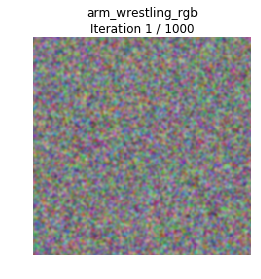

iteration: 1 6.28091287613
iteration: 2 6.49058389664
iteration: 3 6.79840397835
iteration: 4 7.0053730011
iteration: 5 7.23678803444
iteration: 6 7.65003204346
iteration: 7 7.87684988976
iteration: 8 8.11749696732
iteration: 9 8.45582699776
iteration: 10 8.67540788651
iteration: 11 8.91814184189
iteration: 12 9.32290196419
iteration: 13 9.54762983322
iteration: 14 9.79962086678
iteration: 15 10.1902208328
iteration: 16 10.4151859283
iteration: 17 10.6576340199
iteration: 18 11.0550599098
iteration: 19 11.2798278332
iteration: 20 11.5302808285
iteration: 21 11.8896398544
iteration: 22 12.1095929146
iteration: 23 12.3423390388
iteration: 24 12.7319259644


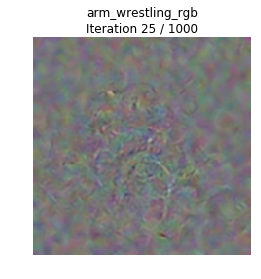

iteration: 25 13.0678489208
iteration: 26 13.3148949146
iteration: 27 13.7249498367
iteration: 28 13.9538888931
iteration: 29 14.2046339512
iteration: 30 14.6042468548
iteration: 31 14.8298299313
iteration: 32 15.0774798393
iteration: 33 15.4820179939
iteration: 34 15.7199938297
iteration: 35 16.0040149689
iteration: 36 16.3700559139
iteration: 37 16.589206934
iteration: 38 16.8434529305
iteration: 39 17.2056798935
iteration: 40 17.4337129593
iteration: 41 17.6913769245
iteration: 42 18.0808048248
iteration: 43 18.3004589081
iteration: 44 18.5414028168
iteration: 45 18.9426789284
iteration: 46 19.1754879951
iteration: 47 19.4306099415
iteration: 48 19.8591659069
iteration: 49 20.0975689888


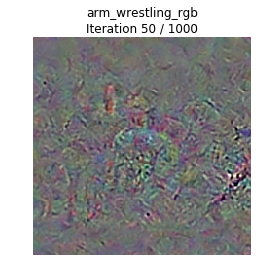

iteration: 50 20.492264986
iteration: 51 20.8599948883
iteration: 52 21.0796358585
iteration: 53 21.3220670223
iteration: 54 21.7176439762
iteration: 55 21.9399418831
iteration: 56 22.1716530323
iteration: 57 22.5457408428
iteration: 58 22.7752928734
iteration: 59 23.0467300415
iteration: 60 23.4688968658
iteration: 61 23.6961269379
iteration: 62 23.9483449459
iteration: 63 24.2987928391
iteration: 64 24.5149810314
iteration: 65 24.7329468727
iteration: 66 25.1213438511
iteration: 67 25.3518960476
iteration: 68 25.6094648838
iteration: 69 26.0426399708
iteration: 70 26.2732348442
iteration: 71 26.5264048576
iteration: 72 26.9514110088
iteration: 73 27.1991729736
iteration: 74 27.4204180241


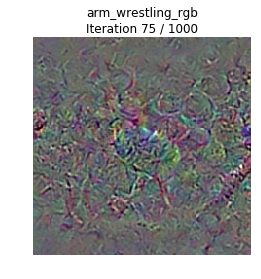

iteration: 75 27.8429629803
iteration: 76 28.070786953
iteration: 77 28.3408749104
iteration: 78 28.6794989109
iteration: 79 28.9068028927
iteration: 80 29.2008039951
iteration: 81 29.6334218979
iteration: 82 29.8673629761
iteration: 83 30.1221868992
iteration: 84 30.5693249702
iteration: 85 30.8029530048
iteration: 86 31.0584349632
iteration: 87 31.4972779751
iteration: 88 31.731623888
iteration: 89 31.9935958385
iteration: 90 32.3410499096
iteration: 91 32.5708930492
iteration: 92 32.8531959057
iteration: 93 33.2869849205
iteration: 94 33.5172870159
iteration: 95 33.767802
iteration: 96 34.1814248562
iteration: 97 34.4111838341
iteration: 98 34.6603388786
iteration: 99 35.0902278423


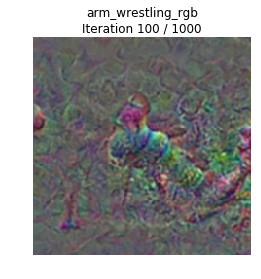

iteration: 100 35.4300529957
iteration: 101 35.6733369827
iteration: 102 36.1100809574
iteration: 103 36.3430089951
iteration: 104 36.6102290154
iteration: 105 37.0374019146
iteration: 106 37.2803058624
iteration: 107 37.555410862
iteration: 108 37.8964560032
iteration: 109 38.1313538551
iteration: 110 38.4182488918
iteration: 111 38.8040468693
iteration: 112 39.0227520466
iteration: 113 39.240530014
iteration: 114 39.6221029758
iteration: 115 39.8499078751
iteration: 116 40.0790128708
iteration: 117 40.4132239819
iteration: 118 40.6341109276
iteration: 119 40.879545927
iteration: 120 41.2797169685
iteration: 121 41.5080108643
iteration: 122 41.7611470222
iteration: 123 42.196655035
iteration: 124 42.43450284


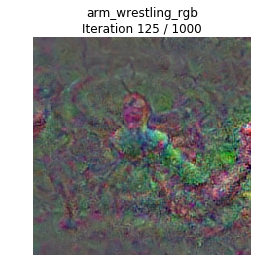

iteration: 125 42.8161289692
iteration: 126 43.1418540478
iteration: 127 43.3686058521
iteration: 128 43.6105928421
iteration: 129 44.0342559814
iteration: 130 44.2545230389
iteration: 131 44.4729290009
iteration: 132 44.8181908131
iteration: 133 45.0416150093
iteration: 134 45.2909629345
iteration: 135 45.6993470192
iteration: 136 45.9275920391
iteration: 137 46.1813240051
iteration: 138 46.621284008
iteration: 139 46.8547730446
iteration: 140 47.1137518883
iteration: 141 47.5560898781
iteration: 142 47.8049650192
iteration: 143 48.0965738297
iteration: 144 48.5163798332
iteration: 145 48.7390120029
iteration: 146 48.9635739326
iteration: 147 49.3427648544
iteration: 148 49.5763669014
iteration: 149 49.8565559387


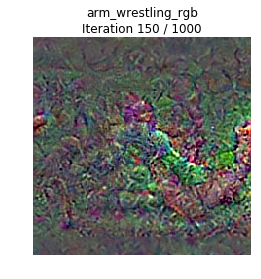

iteration: 150 50.3541378975
iteration: 151 50.5908889771
iteration: 152 50.8830518723
iteration: 153 51.3090128899
iteration: 154 51.5374078751
iteration: 155 51.7654898167
iteration: 156 52.1840519905
iteration: 157 52.4140779972
iteration: 158 52.6576218605
iteration: 159 52.9729590416
iteration: 160 53.1970639229
iteration: 161 53.4450700283
iteration: 162 53.8397948742
iteration: 163 54.0641160011
iteration: 164 54.3032259941
iteration: 165 54.6245808601
iteration: 166 54.8445868492
iteration: 167 55.0696220398
iteration: 168 55.3934829235
iteration: 169 55.6126508713
iteration: 170 55.8367619514
iteration: 171 56.1635859013
iteration: 172 56.3841190338
iteration: 173 56.6149308681
iteration: 174 57.0222468376


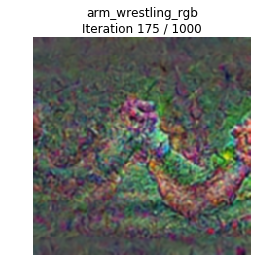

iteration: 175 57.3578009605
iteration: 176 57.5921528339
iteration: 177 57.9728150368
iteration: 178 58.1990728378
iteration: 179 58.453938961
iteration: 180 58.8580868244
iteration: 181 59.1030628681
iteration: 182 59.3807358742
iteration: 183 59.7850420475
iteration: 184 60.0193879604
iteration: 185 60.2811248302
iteration: 186 60.7082898617
iteration: 187 60.9491388798
iteration: 188 61.200289011
iteration: 189 61.5526139736
iteration: 190 61.7806270123
iteration: 191 62.013589859
iteration: 192 62.4432189465
iteration: 193 62.6757309437
iteration: 194 62.9182889462
iteration: 195 63.2342259884
iteration: 196 63.4587569237
iteration: 197 63.6802380085
iteration: 198 63.99573493
iteration: 199 64.2191548347


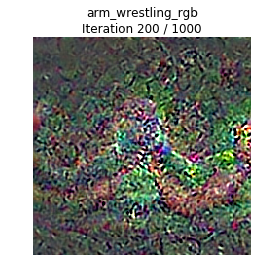

iteration: 200 64.5638239384
iteration: 201 64.878125906
iteration: 202 65.1109559536
iteration: 203 65.5304698944
iteration: 204 65.9140028954
iteration: 205 66.1409649849
iteration: 206 66.3657529354
iteration: 207 66.674893856
iteration: 208 66.8921978474
iteration: 209 67.1363990307
iteration: 210 67.5367269516
iteration: 211 67.7690489292
iteration: 212 67.9991779327
iteration: 213 68.3431899548
iteration: 214 68.5663309097
iteration: 215 68.7947540283
iteration: 216 69.1970620155
iteration: 217 69.4314718246
iteration: 218 69.6820688248
iteration: 219 70.0083320141
iteration: 220 70.2479429245
iteration: 221 70.5280480385
iteration: 222 70.8768780231
iteration: 223 71.1087779999
iteration: 224 71.3762218952


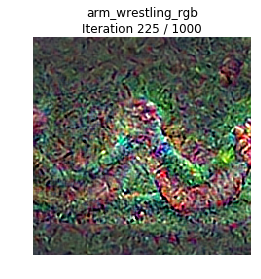

iteration: 225 71.8665020466
iteration: 226 72.0987818241
iteration: 227 72.3491530418
iteration: 228 72.6965818405
iteration: 229 72.9363839626
iteration: 230 73.2279930115
iteration: 231 73.6685390472
iteration: 232 73.9137048721
iteration: 233 74.1993939877
iteration: 234 74.615090847
iteration: 235 74.8588788509
iteration: 236 75.1486709118
iteration: 237 75.6017959118
iteration: 238 75.8427410126
iteration: 239 76.0940840244
iteration: 240 76.4711370468
iteration: 241 76.7189860344
iteration: 242 77.0214350224
iteration: 243 77.425951004
iteration: 244 77.6593959332
iteration: 245 77.9127929211
iteration: 246 78.3406648636
iteration: 247 78.580673933
iteration: 248 78.8429889679
iteration: 249 79.2833998203


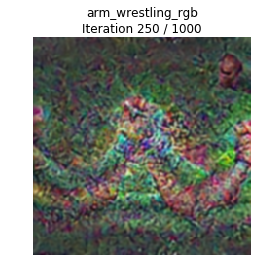

iteration: 250 79.6175539494
iteration: 251 79.852367878
iteration: 252 80.1954729557
iteration: 253 80.4319198132
iteration: 254 80.7301068306
iteration: 255 81.1745679379
iteration: 256 81.4146709442
iteration: 257 81.6846818924
iteration: 258 82.0680689812
iteration: 259 82.2988510132
iteration: 260 82.5391600132
iteration: 261 82.8854320049
iteration: 262 83.1281459332
iteration: 263 83.4267480373
iteration: 264 83.8788850307
iteration: 265 84.1325469017
iteration: 266 84.4298830032
iteration: 267 84.8810999393
iteration: 268 85.1234560013
iteration: 269 85.3704099655
iteration: 270 85.7226400375
iteration: 271 85.9656059742
iteration: 272 86.2606539726
iteration: 273 86.6939120293
iteration: 274 86.9392318726


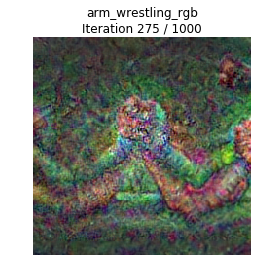

iteration: 275 87.2951619625
iteration: 276 87.6899888515
iteration: 277 87.9347848892
iteration: 278 88.1905720234
iteration: 279 88.6225888729
iteration: 280 88.8671889305
iteration: 281 89.1353168488
iteration: 282 89.5873479843
iteration: 283 89.8361179829
iteration: 284 90.1008429527
iteration: 285 90.5201349258
iteration: 286 90.7692539692
iteration: 287 91.0631639957
iteration: 288 91.4432380199
iteration: 289 91.6734428406
iteration: 290 91.9097399712
iteration: 291 92.2950258255
iteration: 292 92.531252861
iteration: 293 92.7916579247
iteration: 294 93.202121973
iteration: 295 93.4408259392
iteration: 296 93.6999850273
iteration: 297 94.1045689583
iteration: 298 94.3435118198
iteration: 299 94.6018648148


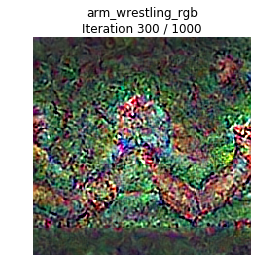

iteration: 300 95.0984699726
iteration: 301 95.3421118259
iteration: 302 95.6064949036
iteration: 303 96.0032918453
iteration: 304 96.246560812
iteration: 305 96.5447609425
iteration: 306 96.9450500011
iteration: 307 97.171587944
iteration: 308 97.4284799099
iteration: 309 97.8623158932
iteration: 310 98.1072409153
iteration: 311 98.375442028
iteration: 312 98.7735610008
iteration: 313 99.0160179138
iteration: 314 99.276597023
iteration: 315 99.693392992
iteration: 316 99.9320118427
iteration: 317 100.194308996
iteration: 318 100.635087013
iteration: 319 100.885558844
iteration: 320 101.159806013
iteration: 321 101.578995943
iteration: 322 101.826336861
iteration: 323 102.102353811
iteration: 324 102.48516202


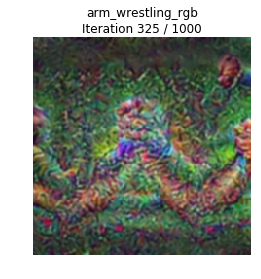

iteration: 325 102.82375598
iteration: 326 103.124159813
iteration: 327 103.549356937
iteration: 328 103.792513847
iteration: 329 104.085371971
iteration: 330 104.524632931
iteration: 331 104.778496027
iteration: 332 105.073622942
iteration: 333 105.505861044
iteration: 334 105.749963045
iteration: 335 106.015534878
iteration: 336 106.447752953
iteration: 337 106.699290991
iteration: 338 106.997615814
iteration: 339 107.437538862
iteration: 340 107.68290782
iteration: 341 107.961931944
iteration: 342 108.419158936
iteration: 343 108.656630039
iteration: 344 108.888936996
iteration: 345 109.242560863
iteration: 346 109.487555027
iteration: 347 109.778802872
iteration: 348 110.172302961
iteration: 349 110.407028913


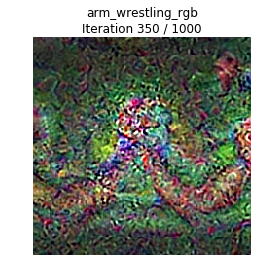

iteration: 350 110.768761873
iteration: 351 111.203076839
iteration: 352 111.453109026
iteration: 353 111.713564873
iteration: 354 112.119182825
iteration: 355 112.362779856
iteration: 356 112.63041687
iteration: 357 113.065141916
iteration: 358 113.308204889
iteration: 359 113.571918964
iteration: 360 113.983767986
iteration: 361 114.230432034
iteration: 362 114.48872304
iteration: 363 114.854599953
iteration: 364 115.091586828
iteration: 365 115.35492301
iteration: 366 115.762799025
iteration: 367 116.0025599
iteration: 368 116.257773876
iteration: 369 116.658318996
iteration: 370 116.911552906
iteration: 371 117.196337938
iteration: 372 117.552731991
iteration: 373 117.791126013
iteration: 374 118.041978836


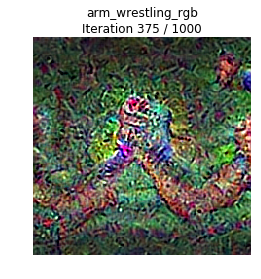

iteration: 375 118.515192986
iteration: 376 118.762840033
iteration: 377 119.060003996
iteration: 378 119.501592875
iteration: 379 119.747474909
iteration: 380 120.017096043
iteration: 381 120.46802187
iteration: 382 120.72034502
iteration: 383 121.022682905
iteration: 384 121.467643976
iteration: 385 121.705834866
iteration: 386 121.941736937
iteration: 387 122.336213827
iteration: 388 122.576411963
iteration: 389 122.850620985
iteration: 390 123.30913496
iteration: 391 123.563073874
iteration: 392 123.844847918
iteration: 393 124.304008007
iteration: 394 124.55724287
iteration: 395 124.819702864
iteration: 396 125.214002848
iteration: 397 125.454818964
iteration: 398 125.731647015
iteration: 399 126.132925987


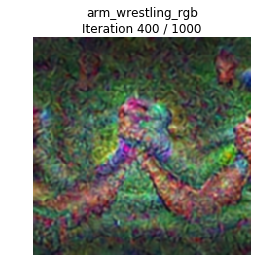

iteration: 400 126.473296881
iteration: 401 126.738251925
iteration: 402 127.151757002
iteration: 403 127.409495831
iteration: 404 127.718101978
iteration: 405 128.173784018
iteration: 406 128.421509027
iteration: 407 128.681964874
iteration: 408 129.117813826
iteration: 409 129.355990887
iteration: 410 129.600934982
iteration: 411 129.99278903
iteration: 412 130.238445997
iteration: 413 130.485546827
iteration: 414 130.817023039
iteration: 415 131.057118893
iteration: 416 131.315346956
iteration: 417 131.706862926
iteration: 418 131.94807291
iteration: 419 132.20292902
iteration: 420 132.560931921
iteration: 421 132.800644875
iteration: 422 133.069042921
iteration: 423 133.482847929
iteration: 424 133.727723837


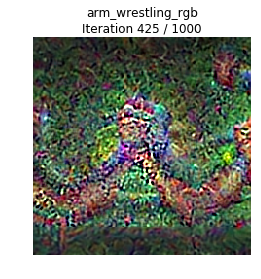

iteration: 425 134.097249031
iteration: 426 134.580289841
iteration: 427 134.834378004
iteration: 428 135.109699011
iteration: 429 135.577100992
iteration: 430 135.82444787
iteration: 431 136.059703827
iteration: 432 136.398000956
iteration: 433 136.633467913
iteration: 434 136.874410868
iteration: 435 137.269141912
iteration: 436 137.518548012
iteration: 437 137.801334858
iteration: 438 138.190238953
iteration: 439 138.458307028
iteration: 440 138.715613842
iteration: 441 139.070721865
iteration: 442 139.324235916
iteration: 443 139.629503012
iteration: 444 140.071173906
iteration: 445 140.314939022
iteration: 446 140.562824011
iteration: 447 140.954088926
iteration: 448 141.208545923
iteration: 449 141.520138979


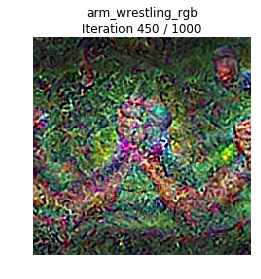

iteration: 450 142.026873827
iteration: 451 142.268827915
iteration: 452 142.535482883
iteration: 453 142.97754097
iteration: 454 143.228965998
iteration: 455 143.505328894
iteration: 456 143.891669989
iteration: 457 144.126080036
iteration: 458 144.369168043
iteration: 459 144.744467974
iteration: 460 144.995786905
iteration: 461 145.265216827
iteration: 462 145.684047937
iteration: 463 145.953217983
iteration: 464 146.247856855
iteration: 465 146.611389875
iteration: 466 146.892128944
iteration: 467 147.146747828
iteration: 468 147.493309021
iteration: 469 147.74367094
iteration: 470 148.04103303
iteration: 471 148.464012861
iteration: 472 148.719452858
iteration: 473 149.019412041
iteration: 474 149.459008932


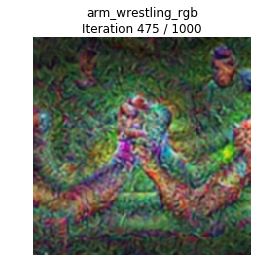

iteration: 475 149.852694035
iteration: 476 150.159051895
iteration: 477 150.603979826
iteration: 478 150.849165916
iteration: 479 151.100347042
iteration: 480 151.462545872
iteration: 481 151.703284979
iteration: 482 151.944811821
iteration: 483 152.324322939
iteration: 484 152.571919918
iteration: 485 152.834295988
iteration: 486 153.194010973
iteration: 487 153.433971882
iteration: 488 153.687198877
iteration: 489 154.101802826
iteration: 490 154.346547842
iteration: 491 154.606065989
iteration: 492 155.029196978
iteration: 493 155.281270027
iteration: 494 155.555742025
iteration: 495 156.002745867
iteration: 496 156.250551939
iteration: 497 156.522249937
iteration: 498 156.947532892
iteration: 499 157.207238913


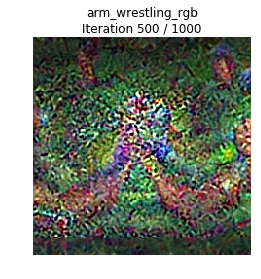

iteration: 500 157.610692024
iteration: 501 158.015159845
iteration: 502 158.26836586
iteration: 503 158.582119942
iteration: 504 159.033660889
iteration: 505 159.30153203
iteration: 506 159.609719038
iteration: 507 160.077272892
iteration: 508 160.339058876
iteration: 509 160.64278698
iteration: 510 161.025614023
iteration: 511 161.268286943
iteration: 512 161.524957895
iteration: 513 161.888422966
iteration: 514 162.13084197
iteration: 515 162.38821888
iteration: 516 162.861373901
iteration: 517 163.116199017
iteration: 518 163.395004034
iteration: 519 163.866220951
iteration: 520 164.113472939
iteration: 521 164.381978989
iteration: 522 164.857038975
iteration: 523 165.113451958
iteration: 524 165.3858459


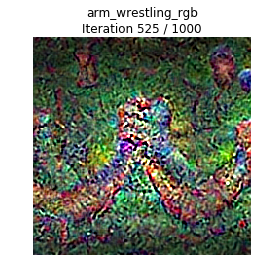

iteration: 525 165.848835945
iteration: 526 166.093282938
iteration: 527 166.346954823
iteration: 528 166.715781927
iteration: 529 166.971679926
iteration: 530 167.276048899
iteration: 531 167.698395014
iteration: 532 167.94647789
iteration: 533 168.212796926
iteration: 534 168.652159929
iteration: 535 168.907801867
iteration: 536 169.153384924
iteration: 537 169.553746939
iteration: 538 169.817831993
iteration: 539 170.1261549
iteration: 540 170.574676037
iteration: 541 170.822293997
iteration: 542 171.080554008
iteration: 543 171.453619957
iteration: 544 171.7110219
iteration: 545 172.027117014
iteration: 546 172.458938837
iteration: 547 172.711851835
iteration: 548 172.989584923
iteration: 549 173.454056978


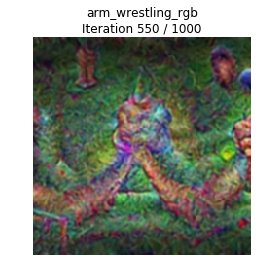

iteration: 550 173.812059879
iteration: 551 174.096388817
iteration: 552 174.540668964
iteration: 553 174.795480013
iteration: 554 175.080303907
iteration: 555 175.548355818
iteration: 556 175.803346872
iteration: 557 176.082188845
iteration: 558 176.473605871
iteration: 559 176.720587015
iteration: 560 176.99472785
iteration: 561 177.420961857
iteration: 562 177.685829878
iteration: 563 177.995261908
iteration: 564 178.424144983
iteration: 565 178.680912018
iteration: 566 178.997414827
iteration: 567 179.473870039
iteration: 568 179.726399899
iteration: 569 179.994786024
iteration: 570 180.402279854
iteration: 571 180.662206888
iteration: 572 180.980077028
iteration: 573 181.425328016
iteration: 574 181.678727865


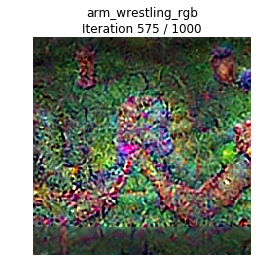

iteration: 575 182.125666857
iteration: 576 182.577584028
iteration: 577 182.835922003
iteration: 578 183.140295029
iteration: 579 183.583284855
iteration: 580 183.842715979
iteration: 581 184.112591028
iteration: 582 184.477725029
iteration: 583 184.723062992
iteration: 584 184.967743874
iteration: 585 185.390817881
iteration: 586 185.661650896
iteration: 587 185.959481001
iteration: 588 186.352270842
iteration: 589 186.613359928
iteration: 590 186.887513876
iteration: 591 187.254794836
iteration: 592 187.497360945
iteration: 593 187.745293856
iteration: 594 188.216785908
iteration: 595 188.473973989
iteration: 596 188.744935036
iteration: 597 189.16464901
iteration: 598 189.423173904
iteration: 599 189.725441933


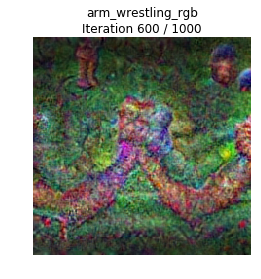

iteration: 600 190.296468973
iteration: 601 190.551723003
iteration: 602 190.805598974
iteration: 603 191.155948877
iteration: 604 191.403802872
iteration: 605 191.676635981
iteration: 606 192.144678831
iteration: 607 192.416731834
iteration: 608 192.725826979
iteration: 609 193.073782921
iteration: 610 193.321532965
iteration: 611 193.602552891
iteration: 612 194.100280046
iteration: 613 194.379437923
iteration: 614 194.661649942
iteration: 615 195.041906834
iteration: 616 195.292222977
iteration: 617 195.576148987
iteration: 618 195.940778017
iteration: 619 196.200742006
iteration: 620 196.519189835
iteration: 621 196.96728301
iteration: 622 197.22596693
iteration: 623 197.497160912
iteration: 624 197.880223989


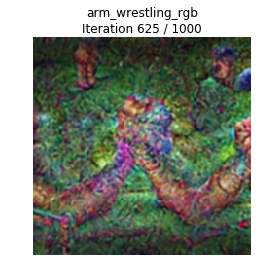

iteration: 625 198.230620861
iteration: 626 198.511023998
iteration: 627 198.906527996
iteration: 628 199.171079874
iteration: 629 199.493494034
iteration: 630 199.926146984
iteration: 631 200.178172827
iteration: 632 200.441727877
iteration: 633 200.817018986
iteration: 634 201.066009998
iteration: 635 201.330014944
iteration: 636 201.679262877
iteration: 637 201.932832003
iteration: 638 202.21359086
iteration: 639 202.604076862
iteration: 640 202.856881857
iteration: 641 203.132772923
iteration: 642 203.567298889
iteration: 643 203.826077938
iteration: 644 204.075388908
iteration: 645 204.437433958
iteration: 646 204.69728303
iteration: 647 205.02212882
iteration: 648 205.474819899
iteration: 649 205.742166042


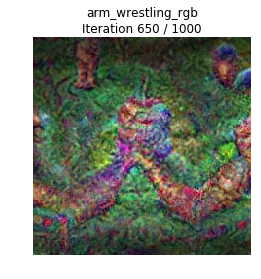

iteration: 650 206.219220877
iteration: 651 206.67660594
iteration: 652 206.935287952
iteration: 653 207.20935297
iteration: 654 207.650197029
iteration: 655 207.919548035
iteration: 656 208.224622965
iteration: 657 208.599210978
iteration: 658 208.851044893
iteration: 659 209.129319906
iteration: 660 209.596765995
iteration: 661 209.873373985
iteration: 662 210.177235842
iteration: 663 210.635890961
iteration: 664 210.900851011
iteration: 665 211.199909925
iteration: 666 211.654472828
iteration: 667 211.915352821
iteration: 668 212.195120811
iteration: 669 212.61698103
iteration: 670 212.871081829
iteration: 671 213.152722836
iteration: 672 213.531419039
iteration: 673 213.784976006
iteration: 674 214.05387187


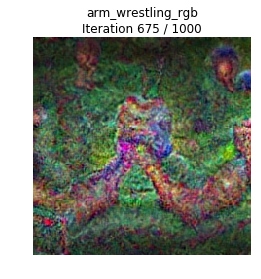

iteration: 675 214.650964975
iteration: 676 214.910049915
iteration: 677 215.188127995
iteration: 678 215.600311995
iteration: 679 215.855123997
iteration: 680 216.131217957
iteration: 681 216.569376945
iteration: 682 216.839506865
iteration: 683 217.136543036
iteration: 684 217.583334923
iteration: 685 217.843683004
iteration: 686 218.117429972
iteration: 687 218.526651859
iteration: 688 218.781668901
iteration: 689 219.056071997
iteration: 690 219.457918882
iteration: 691 219.715448856
iteration: 692 219.989699841
iteration: 693 220.419750929
iteration: 694 220.675952911
iteration: 695 220.968133926
iteration: 696 221.363651991
iteration: 697 221.610190868
iteration: 698 221.883339882
iteration: 699 222.294608831


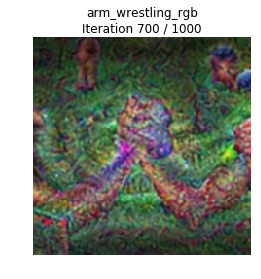

iteration: 700 222.659411907
iteration: 701 222.913957834
iteration: 702 223.326898813
iteration: 703 223.581871033
iteration: 704 223.835369825
iteration: 705 224.209774971
iteration: 706 224.463963985
iteration: 707 224.742830992
iteration: 708 225.154966831
iteration: 709 225.411353827
iteration: 710 225.690104008
iteration: 711 226.072801828
iteration: 712 226.326824903
iteration: 713 226.617952824
iteration: 714 227.099246025
iteration: 715 227.370285988
iteration: 716 227.687376022
iteration: 717 228.139075994
iteration: 718 228.396569967
iteration: 719 228.676198006
iteration: 720 229.114326954
iteration: 721 229.377696037
iteration: 722 229.663851023
iteration: 723 230.13762784
iteration: 724 230.406457901


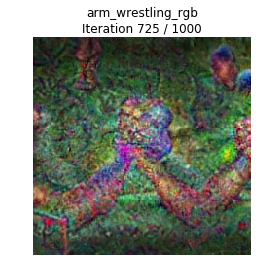

iteration: 725 230.874847889
iteration: 726 231.278513908
iteration: 727 231.532543898
iteration: 728 231.808845043
iteration: 729 232.256232977
iteration: 730 232.532094955
iteration: 731 232.852193832
iteration: 732 233.292949915
iteration: 733 233.551836014
iteration: 734 233.831383944
iteration: 735 234.232168913
iteration: 736 234.489843845
iteration: 737 234.796983957
iteration: 738 235.235864878
iteration: 739 235.503482819
iteration: 740 235.783813953
iteration: 741 236.232731819
iteration: 742 236.497964859
iteration: 743 236.763988972
iteration: 744 237.144768953
iteration: 745 237.402740002
iteration: 746 237.679320812
iteration: 747 238.101274014
iteration: 748 238.364935875
iteration: 749 238.652457952


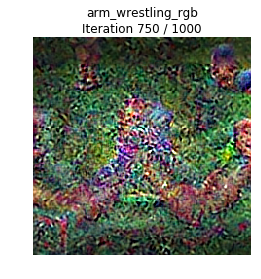

iteration: 750 239.160745859
iteration: 751 239.418530941
iteration: 752 239.698829889
iteration: 753 240.334161043
iteration: 754 240.611943007
iteration: 755 240.946720839
iteration: 756 241.345218897
iteration: 757 241.603586912
iteration: 758 241.873631001
iteration: 759 242.328320026
iteration: 760 242.59513092
iteration: 761 242.892066956
iteration: 762 243.368861914
iteration: 763 243.649261951
iteration: 764 243.935833931
iteration: 765 244.348044872
iteration: 766 244.614658833
iteration: 767 244.888089895
iteration: 768 245.31349802
iteration: 769 245.593683004
iteration: 770 245.903352976
iteration: 771 246.287529945
iteration: 772 246.544445992
iteration: 773 246.807063818
iteration: 774 247.251471043


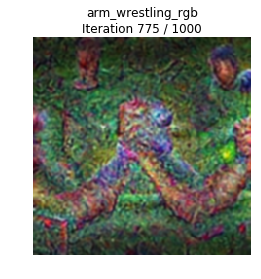

iteration: 775 247.624017954
iteration: 776 247.907161951
iteration: 777 248.297749996
iteration: 778 248.570674896
iteration: 779 248.865938902
iteration: 780 249.364609003
iteration: 781 249.644323826
iteration: 782 249.943519831
iteration: 783 250.365859985
iteration: 784 250.642944813
iteration: 785 250.945902824
iteration: 786 251.407966852
iteration: 787 251.68835783
iteration: 788 252.027712822
iteration: 789 252.516355991
iteration: 790 252.787885904
iteration: 791 253.075800896
iteration: 792 253.535732031
iteration: 793 253.820077896
iteration: 794 254.117389917
iteration: 795 254.538408041
iteration: 796 254.831485987
iteration: 797 255.163161039
iteration: 798 255.628684044
iteration: 799 255.913949966


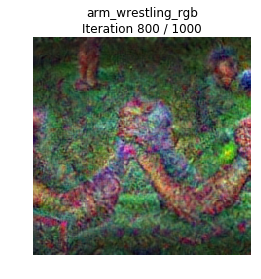

iteration: 800 256.343976021
iteration: 801 256.770478964
iteration: 802 257.054885864
iteration: 803 257.357025862
iteration: 804 257.783689976
iteration: 805 258.06280899
iteration: 806 258.37548089
iteration: 807 258.84759593
iteration: 808 259.138789892
iteration: 809 259.466878891
iteration: 810 259.884011984
iteration: 811 260.154275894
iteration: 812 260.452620029
iteration: 813 260.912345886
iteration: 814 261.181883812
iteration: 815 261.45448494
iteration: 816 261.901671886
iteration: 817 262.177616835
iteration: 818 262.469878912
iteration: 819 262.916910887
iteration: 820 263.186223984
iteration: 821 263.481832981
iteration: 822 263.906783819
iteration: 823 264.17907095
iteration: 824 264.470185995


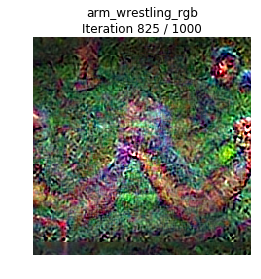

iteration: 825 265.004040003
iteration: 826 265.267241001
iteration: 827 265.539572954
iteration: 828 265.966951847
iteration: 829 266.262276888
iteration: 830 266.596226931
iteration: 831 267.03826499
iteration: 832 267.31405282
iteration: 833 267.606143951
iteration: 834 267.965317965
iteration: 835 268.242722034
iteration: 836 268.567409992
iteration: 837 269.002041817
iteration: 838 269.278304815
iteration: 839 269.599177837
iteration: 840 270.048246861
iteration: 841 270.321188927
iteration: 842 270.619997978
iteration: 843 271.087023973
iteration: 844 271.356595039
iteration: 845 271.650447845
iteration: 846 272.078092813
iteration: 847 272.358599901
iteration: 848 272.684629917
iteration: 849 273.120376825


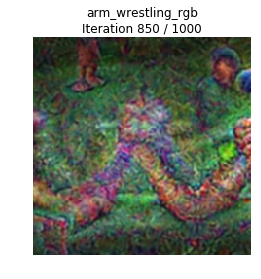

iteration: 850 273.498150826
iteration: 851 273.837069035
iteration: 852 274.303251982
iteration: 853 274.574928999
iteration: 854 274.864619017
iteration: 855 275.320294857
iteration: 856 275.601541996
iteration: 857 275.93144393
iteration: 858 276.361306906
iteration: 859 276.639214993
iteration: 860 276.971654892
iteration: 861 277.443272829
iteration: 862 277.716141939
iteration: 863 278.00722599
iteration: 864 278.417753935
iteration: 865 278.686159849
iteration: 866 278.974967957
iteration: 867 279.38160491
iteration: 868 279.648015022
iteration: 869 279.931977987
iteration: 870 280.361466885
iteration: 871 280.645295858
iteration: 872 280.967985868
iteration: 873 281.389242887
iteration: 874 281.665127993


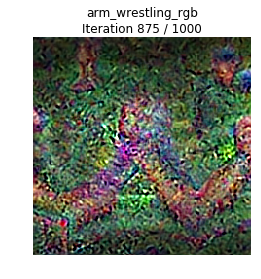

iteration: 875 282.092514038
iteration: 876 282.542532921
iteration: 877 282.820184946
iteration: 878 283.107947826
iteration: 879 283.528347969
iteration: 880 283.800051928
iteration: 881 284.10590291
iteration: 882 284.566052914
iteration: 883 284.840034008
iteration: 884 285.136127949
iteration: 885 285.585852861
iteration: 886 285.872650862
iteration: 887 286.193974018
iteration: 888 286.607147932
iteration: 889 286.872196913
iteration: 890 287.145418882
iteration: 891 287.528829813
iteration: 892 287.802450895
iteration: 893 288.124225855
iteration: 894 288.555510044
iteration: 895 288.836279869
iteration: 896 289.13408494
iteration: 897 289.591706991
iteration: 898 289.864219904
iteration: 899 290.164328814


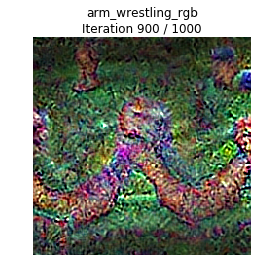

iteration: 900 290.641420841
iteration: 901 290.905733824
iteration: 902 291.174286842
iteration: 903 291.596621037
iteration: 904 291.868927002
iteration: 905 292.161897898
iteration: 906 292.591187
iteration: 907 292.854763031
iteration: 908 293.122457027
iteration: 909 293.54170084
iteration: 910 293.820847034
iteration: 911 294.121523857
iteration: 912 294.588943958
iteration: 913 294.861980915
iteration: 914 295.154511929
iteration: 915 295.569924831
iteration: 916 295.834630013
iteration: 917 296.106679916
iteration: 918 296.549681902
iteration: 919 296.836220026
iteration: 920 297.128629923
iteration: 921 297.557485819
iteration: 922 297.840422869
iteration: 923 298.152405024
iteration: 924 298.622648001


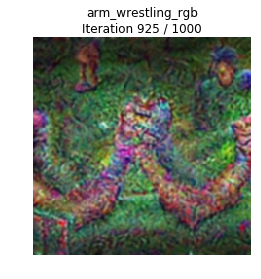

iteration: 925 299.076966047
iteration: 926 299.373142958
iteration: 927 299.814194918
iteration: 928 300.113379955
iteration: 929 300.443485022
iteration: 930 300.883771896
iteration: 931 301.153689861
iteration: 932 301.428566933
iteration: 933 301.838452816
iteration: 934 302.138437033
iteration: 935 302.434299946
iteration: 936 302.894099951
iteration: 937 303.176209927
iteration: 938 303.483839035
iteration: 939 303.928349018
iteration: 940 304.211447001
iteration: 941 304.552245855
iteration: 942 304.979260921
iteration: 943 305.256012917
iteration: 944 305.557760954
iteration: 945 306.011334896
iteration: 946 306.30169487
iteration: 947 306.629451036
iteration: 948 307.04658103
iteration: 949 307.328402996


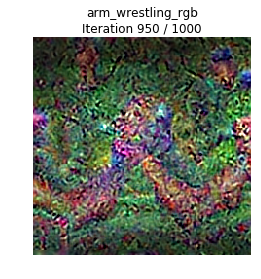

iteration: 950 307.827360868
iteration: 951 308.335037947
iteration: 952 308.619153023
iteration: 953 308.926540852
iteration: 954 309.360885859
iteration: 955 309.646087885
iteration: 956 309.98613596
iteration: 957 310.397402048
iteration: 958 310.676039934
iteration: 959 311.016522884
iteration: 960 311.431607962
iteration: 961 311.705332994
iteration: 962 312.011196852
iteration: 963 312.460898876
iteration: 964 312.743178844
iteration: 965 313.022722006
iteration: 966 313.445104837
iteration: 967 313.72238183
iteration: 968 314.019392014
iteration: 969 314.430642843
iteration: 970 314.712663889
iteration: 971 315.007243872
iteration: 972 315.459414005
iteration: 973 315.743618965
iteration: 974 316.044989824


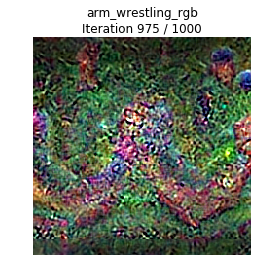

iteration: 975 316.558795929
iteration: 976 316.829048872
iteration: 977 317.105401993
iteration: 978 317.555380821
iteration: 979 317.848145962
iteration: 980 318.188555956
iteration: 981 318.667747974
iteration: 982 318.947703838
iteration: 983 319.260243893
iteration: 984 319.733968019
iteration: 985 320.009243011
iteration: 986 320.280102015
iteration: 987 320.66532588
iteration: 988 320.936513901
iteration: 989 321.226382971
iteration: 990 321.629204988
iteration: 991 321.911278009
iteration: 992 322.238960981
iteration: 993 322.675485849
iteration: 994 322.950673819
iteration: 995 323.240561962
iteration: 996 323.684584856
iteration: 997 323.954269886
iteration: 998 324.226564884
iteration: 999 324.636206865
file_name experiments_rgb/arm_wrestling/arm_wrestling_rgb{}.png


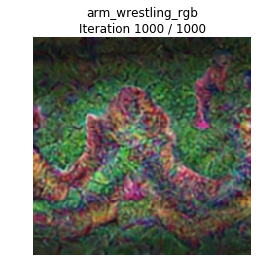

In [6]:
"""
Run RGB visualization only
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # this line may vary depending on hardware
print(model_logits)
print(rgb_input)
target = 6 # change this to the desired class
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # number of frames must be >= 9 or else kernel crashes
        rgb_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name, 
                                   stream_type='rgb', scale_every=1000)

The cell below is used to generate all Optical Flow Visualizations. The hyperparameters inputted below were the ones we found to be best, but we were unable to ever create any good Optical Flow results that were interpretable. 

In [ ]:
"""
Run FLOW visualization only.
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # this line may vary depending on hardware
print(model_logits)
print(flow_input)
target = 171
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        flow_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, 
                                                     action_name + "test", stream_type='flow', num_frames=25, 
                                                     num_iterations=1000, l2_reg=1e-2, learning_rate=1.5, 
                                                     blur_every=10, max_jitter=32, sigma=.5)

In [7]:
"""
Print all classes
"""
indexes = range(len(kinetics_classes))
class_to_index = dict(zip(kinetics_classes, indexes))
index_to_class = dict(zip(indexes, kinetics_classes))
print(index_to_class)


{0: 'abseiling', 1: 'air drumming', 2: 'answering questions', 3: 'applauding', 4: 'applying cream', 5: 'archery', 6: 'arm wrestling', 7: 'arranging flowers', 8: 'assembling computer', 9: 'auctioning', 10: 'baby waking up', 11: 'baking cookies', 12: 'balloon blowing', 13: 'bandaging', 14: 'barbequing', 15: 'bartending', 16: 'beatboxing', 17: 'bee keeping', 18: 'belly dancing', 19: 'bench pressing', 20: 'bending back', 21: 'bending metal', 22: 'biking through snow', 23: 'blasting sand', 24: 'blowing glass', 25: 'blowing leaves', 26: 'blowing nose', 27: 'blowing out candles', 28: 'bobsledding', 29: 'bookbinding', 30: 'bouncing on trampoline', 31: 'bowling', 32: 'braiding hair', 33: 'breading or breadcrumbing', 34: 'breakdancing', 35: 'brush painting', 36: 'brushing hair', 37: 'brushing teeth', 38: 'building cabinet', 39: 'building shed', 40: 'bungee jumping', 41: 'busking', 42: 'canoeing or kayaking', 43: 'capoeira', 44: 'carrying baby', 45: 'cartwheeling', 46: 'carving pumpkin', 47: 'cat